In [1]:
#Set up DRWatson
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
# Load relevant fuctions
include("/home/jm2386/Active_Lattice/src/pm_pde_functions.jl")
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl")

loaded


fake_spin_boundary (generic function with 1 method)

In [3]:
# set parameters
ϕa = 0.6
ϕp = 0.1
Pe = 7.5
#
ρ = ϕa+ϕp
χ = ϕa/ρ
pert = "pm_lin"
    T  = 0.1
    δ  = 1e-4
    save_interval = 0.0001
    Dx = 1. 
    Dθ = 10000.0
    Nx = 512
    Nθ = 2
name = "pm_bin_test_9_pde_δ=$(δ)_l=$(1/sqrt(Dθ))"
#
param = pde_param_pm(; name = name, 
                                ρ = ρ, Pe = Pe, χ = χ, T = T, 
                                Dθ = Dθ, δt = 1e-5, Nx = Nx, Nθ = Nθ, 
                                save_interval = save_interval, max_steps = 1e7,
                                pert = pert, δ = δ,
);#compute bindoal
Pe = 10.0


(0.35985638771544043, 0.9693916139039973)

In [2]:
# set parameters
params = []
Pe = 7.5
pert = "pm_lin"
    T = 0.05
    save_interval = 0.001
    δ  = 1e-4
    Dx = 1. 
    Dθ = 400.0
    Nx = 2^10
    Nθ = 2
    δt = 1e-8
#
#load binodal values
name = "pm_pde_binodal_run_δ=$(δ)_l=$(1/sqrt(Dθ))"
#
filename = "/store/DAMTP/jm2386/Active_Lattice/data/binodal/Pe=$(Pe).jld2"
data = wload(filename)
@unpack Pe, γs, ϕ1s, ϕ2s, average_ϕs, χs = data
#create params
params = []
γ_length = length(γs)
n_lines = 40
interval = Int(round(γ_length/n_lines))
γs          = γs[interval:(interval):Int64(round(γ_length))]
average_ϕs  = average_ϕs[interval:(interval):Int64(round(γ_length))]
map(average_ϕs, γs) do ρ, γ
        χ = (1-γ*(1-ρ))/ρ
        param = pde_param_pm(; name = name, 
                                ρ = ρ, Pe = Pe, χ = χ, T = T, 
                                Dθ = Dθ, δt = δt, Nx = Nx, Nθ = Nθ, 
                                save_interval = save_interval, max_steps = 1e7,
                                pert = pert, δ = δ,
        )
        push!(params,param)
end

i = 25
param = params[i]
γ = γs[i]
ϕl = ϕ1s[i]
ϕg = ϕ2s[i]

0.9426308286357952

In [4]:
initial_Δ = 1e-4;
max_iter = 40;
tol = 1e-15;
atol = 1e-12;
rho_max = (1-10e-20);

find_sol, lower_limits, upper_limits = colapse_sol_interval(;Pe = Pe, γ = γ, rho_max = rho_max, initial_Δ = initial_Δ, max_iter = max_iter, tol = tol, atol = atol);
ϕg = lower_limits[1]
ϕl = upper_limits[1]
ϕg, ϕl 

(0.7487303079808966, 0.9168112838695733)

In [5]:
#compute velocitites
ϵ = 1e-15
Δx = 0.0001
Δy = 0.0001

#compute solution
J = zeros(2,2)
u = zeros(2)
parameters = (Pe, γ, ϕg, ϕl)
t = 0.
J = f_jac(J,u,parameters,t)
values, vectors = eigen(J)
evector2 = vectors[:,2]

ff = ODEFunction(f;jac=f_jac)
ϵ = 1e-15
initial_position = [ϕg 0.0] + ϵ*evector2

x = collect((ϕg-0.1+ϵ*evector2[1]):Δx:(0.9999))
y = collect((-0.999+ϵ*evector2[2]):Δy:0.999)

xx = [x̃ for x̃ ∈ x, ỹ ∈ y]
    yy = [ỹ for x̃ ∈ x, ỹ ∈ y]
    Nx = length(x)
    Ny = length(y)
    v = zeros(Nx,Ny,2)
    for i in 1:Nx, j in 1:Ny
        ρ = x[i]
        m = y[j]
        v[i,j,1] = Pe*(1-ρ)*m
        v[i,j,2] = -Pe*m^2 + Pe*( (1-γ*(1-ρ) )*self_diff(ρ) -( 1-γ*(1- ϕg) )*self_diff(ϕg) )/self_diff(ρ) -(2/Pe)*log( (1-ρ)/(1-ϕg) )/self_diff(ρ)
    end

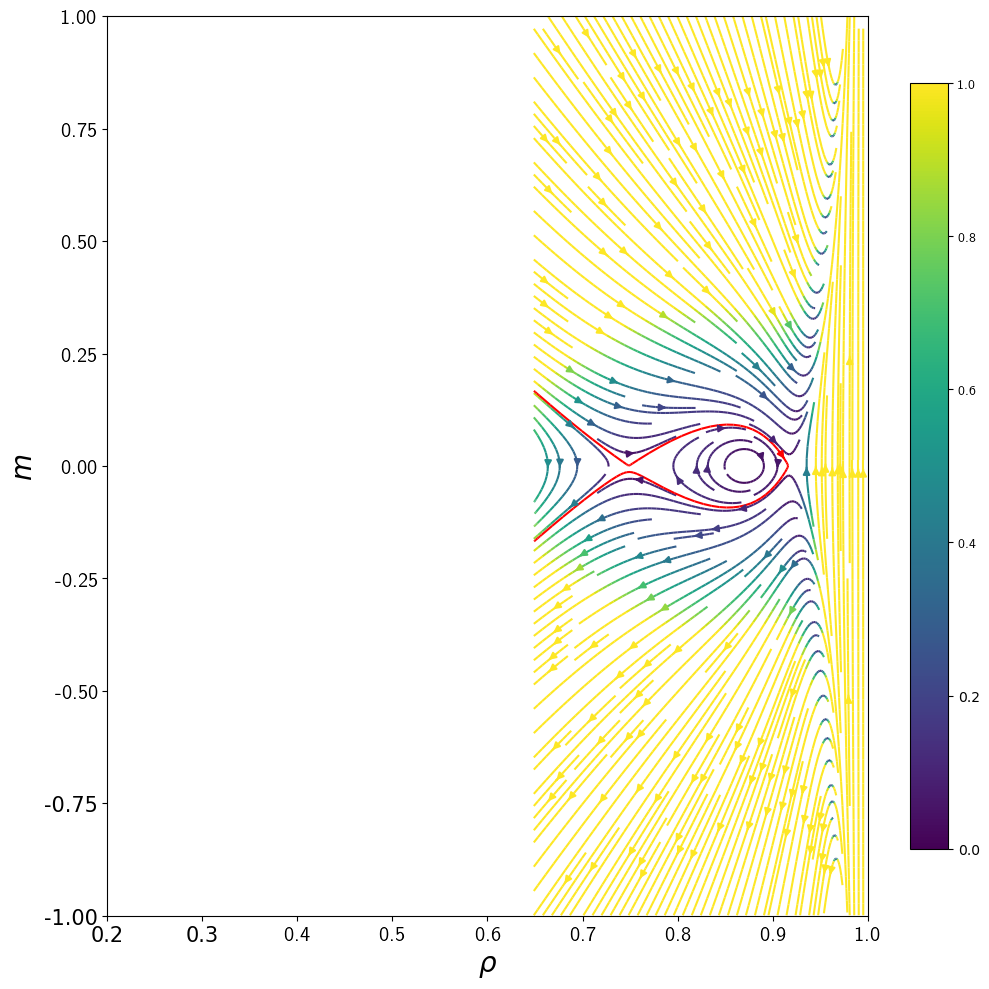

In [9]:
#plot fig
PyPlot.close("all")
fig, ax = plt.subplots(1, 1, figsize=(10,10))
    max_value = 1
    absmag  = min.(sqrt.(v[:,:,1].^2+v[:,:,2].^2), max_value)
    colmap = PyPlot.plt.cm.viridis
    streamlines = ax.streamplot(xx', yy', v[:,:,1]', v[:,:,2]', color = absmag', cmap = colmap, density = 2.5)#4
    norm1 = matplotlib.colors.Normalize(vmin=0., vmax= max_value);
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm1, cmap = colmap), ax = ax, fraction = 0.0455)
initial_position = [ϕg 0.0] + ϵ*[evector2[1] evector2[2]] 
ax.streamplot(xx', yy', v[:,:,1]', v[:,:,2]', color="red", start_points= initial_position)
# fig options
rc("text", usetex=true)
    #ax.yaxis.set_ticks(ytic)
    axlim = [0.2, 1.0, -1.0, 1.0]
    ax.xaxis.set_tick_params(labelsize=15)
    ax.xaxis.tick_bottom()
    ax.yaxis.set_tick_params(labelsize=15)
    ax.axis(axlim)
    #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
    ax.set_xlabel(L"\rho",fontsize=20)
    ax.set_ylabel(L"m", fontsize=20)
    #ax.legend(loc = "upper left", fontsize=20)
    #ax.set_aspect(0.25*Δρ/ΔPe)
    #title = latexstring("\$ \\ell = $(round(1/sqrt(Dθ); digits = 2)), \\chi = $(χ) \$")
    #ax.set_title(title,fontsize=20)
    fig.tight_layout()
display(fig)

In [ ]:
#save fig
name = "Streamplot_Pe=$(Pe)"
    pathname = "/store/DAMTP/jm2386/Active_Lattice/plots/active_passive_1d/$(name)";
    mkpath(pathname)
    filename = "/store/DAMTP/jm2386/Active_Lattice/plots/active_passive_1d/$(name)/Streamplot.pdf";
    PyPlot.savefig(filename,dpi = 100, format = "pdf") #bbox_extra_artists=( ldg,)
##